# Main Content
* Training and testting Generator model in CIFAR10 dataset 
* Then Training and Testing Classifier model in CIFAR10 dataset to compare performance with classifier model when input is original image and privacy image (from CIFAR100)
* We using ResNet18 for base classfier model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
import functools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [ ]:
class SkipConnection(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,submodule=None, outermost=False, innermost=False, 
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_function=nn.Sigmoid):
        super(SkipConnection, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            if output_function == nn.Tanh:
                up = [uprelu, upconv, nn.Tanh()]
            else:
                up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32,
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_function=nn.Sigmoid):
        super(Generator, self).__init__()
        # construct unet structure
        unet_block = SkipConnection(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        unet_block = SkipConnection(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer, output_function=output_function)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)

In [ ]:
device = torch.device('cuda:0')

In [ ]:
# Build ResNet 18 Module 

# https://github.com/kuangliu/pytorch-cifar

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
generator = Generator(input_nc=6, output_nc=3)
generator = generator.to(device)
generator.apply(weights_init)

classifier = ResNet18(100)
classifier = classifier.to(device)
classifier.apply(weights_init)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
def prepare_dataloader(num_workers=8,
                       train_batch_size=128,
                       eval_batch_size=256):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_set = torchvision.datasets.CIFAR10(root="data",
                                             train=True,
                                             download=True,
                                             transform=train_transform)
    
    test_set = torchvision.datasets.CIFAR10(root="data",
                                            train=False,
                                            download=True,
                                            transform=test_transform)

    train_sampler = torch.utils.data.RandomSampler(train_set)
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=train_batch_size,
                                               sampler=train_sampler,
                                               num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=eval_batch_size,
                                              sampler=test_sampler,
                                              num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
train_loader, test_loader = prepare_dataloader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# MSE loss
mse_criterion = nn.MSELoss()

ce_criterion = nn.CrossEntropyLoss()

In [ ]:
optimizerG = optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))

optimizerC = optim.Adam(classifier.parameters(), lr=0.01, betas=(0.5, 0.999))

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
transform = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))

In [ ]:
# @title Bộ 3 ảnh: Container - real - privacy
def show_images(images):
    grid_img = torchvision.utils.make_grid(images, nrow=3)
    plt.imshow(grid_img.permute(1,2,0))
    plt.show()

In [ ]:
best_generator_loss = 1

In [ ]:
best_classifier_loss = 1

In [ ]:
# Training generator 

def train_generator(train_loader, epoch, generator, mse_criterion, cuda=True, show=True):
    generator.train()
    
    g_losses = AverageMeter()
    
    output_images = []

    for i, (image, label) in enumerate(train_loader):
        generator.zero_grad()

        # Select half dataset for container images
        pivot = len(image) // 2 
        container_image = image[0:pivot, :, :, :]
        real_image = image[pivot:pivot*2, :, :, :]
        real_label = label[pivot:pivot*2]

        # Create input of generator (6-dims: batch_size x 6 x 32 x 32)
        gen_input = torch.cat([container_image, real_image], dim=1)
        
        # To cuda
        if cuda:
            container_image = container_image.to(device)
            real_image = real_image.to(device)
            real_label = real_label.to(device)
            gen_input = gen_input.to(device)

        # Create variable
        gen_input_v = Variable(gen_input)
        container_image_v = Variable(container_image)

        # Output of model 
        privacy_image = generator(gen_input_v)
        
        if i % 100 == 0 and show:
            index = random.randint(0, pivot - 1)
            output_images.extend([container_image[index].cpu(), real_image[index].cpu(), privacy_image[index].cpu()])

        # Calculate loss 
        g_loss = mse_criterion(privacy_image, container_image_v)
        
        # Average loss 
        g_losses.update(g_loss.data, pivot)
        
        # Backward
        g_loss.backward()

        optimizerG.step()
    
    print('Training generator - Epoch {} g_loss = {}'.format(epoch, g_losses.avg))
    # Show some output images
    if show:
        show_images(output_images)

In [ ]:
#@title Ảnh đầu vào sẽ đưa qua trained generator model (với container không phải là ảnh lấy ngẫu nhiên trong dataset àm sẽ là ảnh đen: container_image = torch.zeros(image.shape)) sau đó mới đưa vào train
# Training classifier 

def train_classifier(train_loader, epoch, generator, classifier, ce_criterion, cuda=True, show=True):
    generator.eval()
    classifier.train()

    c_losses = AverageMeter() 
    
    correct = 0
    total = 0

    for i, (image, label) in enumerate(train_loader):
        generator.zero_grad()
        classifier.zero_grad()
        
        # Select half dataset for container images
        pivot = len(image) 
        container_image = torch.zeros(image.shape)

        # Create input of generator (6-dims: batch_size x 6 x 32 x 32)
        gen_input = torch.cat([container_image, image], dim=1)
        
        # To cuda
        if cuda:
            container_image = container_image.to(device)
            image = image.to(device)
            label = label.to(device)
            gen_input = gen_input.to(device)

        # Create variable
        gen_input_v = Variable(gen_input)
        container_image_v = Variable(container_image)

        # Output of model 
        with torch.no_grad():
            privacy_image = generator(gen_input_v)
        
        pred_label = classifier(privacy_image)
        pred_label = pred_label.to(device)

        # Calculate loss 
        c_loss = ce_criterion(pred_label, label)
        
        # Average loss 
        c_losses.update(c_loss.data, pivot)
        
        # Backward
        c_loss.backward()

        optimizerC.step()
        
        # Calculate accuracy
        _, predicted = pred_label.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
    
    print('Training classifier - Epoch {} c_loss = {} acc = {}'.format(epoch, c_losses.avg, correct/total))

In [ ]:
def test_generator(test_loader, generator, mse_criterion, cuda=True, show=True):    
    global best_generator_loss
    
    generator.eval()
    
    g_losses = AverageMeter() 
    
    output_images = []
    
    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            # Select half dataset for container images
            pivot = len(image) // 2 
            container_image = image[0:pivot, :, :, :]
            real_image = image[pivot:pivot*2, :, :, :]
            real_label = label[pivot:pivot*2]

            gen_input = torch.cat([container_image, real_image], dim=1)

            # To cuda
            if cuda:
                container_image = container_image.to(device)
                real_image = real_image.to(device)
                real_label = real_label.to(device)
                gen_input = gen_input.to(device)

            gen_input_v = Variable(gen_input)
            container_image_v = Variable(container_image)

            # Output of model 
            privacy_image = generator(gen_input_v)
            
            if i % 100 == 0 and show:
                index = random.randint(0, pivot - 1)
                output_images.extend([container_image[index].cpu(), real_image[index].cpu(), privacy_image[index].cpu()])
            
            # Calculate loss 
            g_loss = mse_criterion(privacy_image, container_image_v)

            # Average loss 
            g_losses.update(g_loss.data, pivot)
    
    
    print('Testing generator - g_loss = {}'.format(g_losses.avg))    
    
    # Save checkpoint 
    if g_losses.avg < best_generator_loss:
        best_generator_loss = g_losses.avg
        torch.save(generator.state_dict(), '/content/drive/MyDrive/Colab Notebooks/checkpoints/best_generator_loss.pth')
        print('Save best checkpoint with loss {}'.format(g_losses.avg))
    # Show some output images
    if show:
        show_images(output_images)        

In [ ]:
def test_classifier(test_loader, generator, classifier, ce_criterion, cuda=True, show=True):
    global best_classifier_loss
    generator.eval()
    classifier.eval()
 
    c_losses = AverageMeter()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            # Select half dataset for container images
            pivot = len(image) 
            
            container_image = torch.zeros(image.shape)
            
            gen_input = torch.cat([container_image, image], dim=1)

            # To cuda
            if cuda:
                container_image = container_image.to(device)
                image = image.to(device)
                label = label.to(device)
                gen_input = gen_input.to(device)

            gen_input_v = Variable(gen_input)
            container_image_v = Variable(container_image)

            # Output of model 
            privacy_image = generator(gen_input_v)
            pred_label = classifier(privacy_image)
            
            # Calculate loss 
            c_loss = ce_criterion(pred_label, label)

            # Average loss 
            c_losses.update(c_loss.data, pivot)

            # Calculate accuracy
            _, predicted = pred_label.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
    
    print('Testing classifier - Epoch {} c_loss = {} acc = {}'.format(epoch, c_losses.avg, correct/total))         
    # Save checkpoint 
    if c_losses.avg < best_classifier_loss:
        best_classifier_loss = c_losses.avg
        torch.save(classifier.state_dict(), '/content/drive/MyDrive/Colab Notebooks/checkpoints/best_classifier_loss.pth')
        print('Save best checkpoint with loss {}'.format(c_losses.avg))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training generator - Epoch 0 g_loss = 0.0058787791058421135


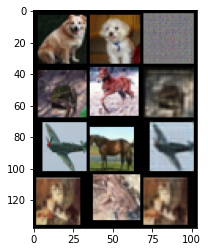

Testing generator - g_loss = 0.00159566814545542
Save best checkpoint with loss 0.00159566814545542


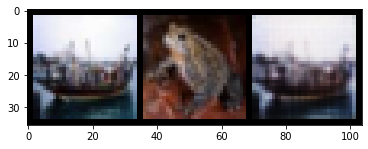

Training generator - Epoch 1 g_loss = 0.0016931614372879267
Testing generator - g_loss = 0.0027963914908468723
Training generator - Epoch 2 g_loss = 0.0013452564598992467
Testing generator - g_loss = 0.0026808760594576597
Training generator - Epoch 3 g_loss = 0.0011773926671594381
Testing generator - g_loss = 0.0011944378493353724
Save best checkpoint with loss 0.0011944378493353724
Training generator - Epoch 4 g_loss = 0.0011596321128308773
Testing generator - g_loss = 0.0011705307988449931
Save best checkpoint with loss 0.0011705307988449931
Training generator - Epoch 5 g_loss = 0.0027760015800595284
Testing generator - g_loss = 0.002346200402826071
Training generator - Epoch 6 g_loss = 0.0012727255234494805
Testing generator - g_loss = 0.0011198666179552674
Save best checkpoint with loss 0.0011198666179552674
Training generator - Epoch 7 g_loss = 0.0010341526940464973
Testing generator - g_loss = 0.0010785736376419663
Save best checkpoint with loss 0.0010785736376419663
Training gen

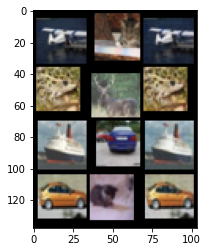

Testing generator - g_loss = 0.000989604857750237


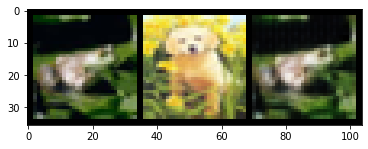

Training generator - Epoch 21 g_loss = 0.0008023316040635109
Testing generator - g_loss = 0.00105422327760607
Training generator - Epoch 22 g_loss = 0.0007586580468341708
Testing generator - g_loss = 0.001082234550267458
Training generator - Epoch 23 g_loss = 0.0007169588352553546
Testing generator - g_loss = 0.002169890096411109
Training generator - Epoch 24 g_loss = 0.0006631494616158307
Testing generator - g_loss = 0.0038411044515669346
Training generator - Epoch 25 g_loss = 0.0006326357834041119
Testing generator - g_loss = 0.0005473407218232751
Save best checkpoint with loss 0.0005473407218232751
Training generator - Epoch 26 g_loss = 0.0006833776133134961
Testing generator - g_loss = 0.0005884745623916388
Training generator - Epoch 27 g_loss = 0.0006059969309717417
Testing generator - g_loss = 0.00045818861690349877
Save best checkpoint with loss 0.00045818861690349877
Training generator - Epoch 28 g_loss = 0.000595242774579674
Testing generator - g_loss = 0.0005060042603872716
T

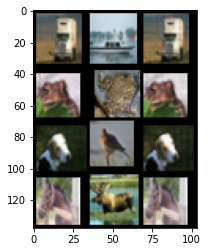

Testing generator - g_loss = 0.0007905327947810292


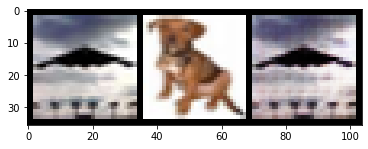

Training generator - Epoch 41 g_loss = 0.0005280362092889845
Testing generator - g_loss = 0.0012374073266983032
Training generator - Epoch 42 g_loss = 0.0005045026773586869
Testing generator - g_loss = 0.0006717311916872859
Training generator - Epoch 43 g_loss = 0.000569254974834621
Testing generator - g_loss = 0.0009039886062964797
Training generator - Epoch 44 g_loss = 0.0005150873330421746
Testing generator - g_loss = 0.0005642258911393583
Training generator - Epoch 45 g_loss = 0.0005176526610739529
Testing generator - g_loss = 0.0006818415713496506
Training generator - Epoch 46 g_loss = 0.0004695567477028817
Testing generator - g_loss = 0.0008939328836277127
Training generator - Epoch 47 g_loss = 0.0004890075069852173
Testing generator - g_loss = 0.0011519226245582104
Training generator - Epoch 48 g_loss = 0.0004908825503662229
Testing generator - g_loss = 0.0006548934034071863
Training generator - Epoch 49 g_loss = 0.000531788042280823
Testing generator - g_loss = 0.00044521878589

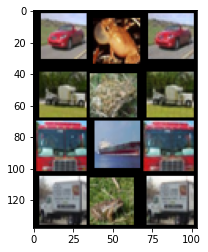

Testing generator - g_loss = 0.0008833407191559672


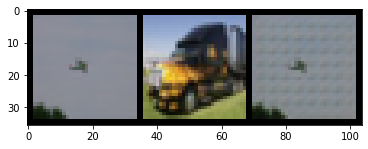

Training generator - Epoch 61 g_loss = 0.00043742687557823956
Testing generator - g_loss = 0.0004552227910608053
Training generator - Epoch 62 g_loss = 0.00041326196515001357
Testing generator - g_loss = 0.00040598519262857735
Save best checkpoint with loss 0.00040598519262857735
Training generator - Epoch 63 g_loss = 0.00043009105138480663
Testing generator - g_loss = 0.0004881401837337762
Training generator - Epoch 64 g_loss = 0.00040898993029259145
Testing generator - g_loss = 0.00045661372132599354
Training generator - Epoch 65 g_loss = 0.0004274372768122703
Testing generator - g_loss = 0.0013472011778503656
Training generator - Epoch 66 g_loss = 0.00042072770884260535
Testing generator - g_loss = 0.0005286558880470693
Training generator - Epoch 67 g_loss = 0.00039717252366244793
Testing generator - g_loss = 0.0008419968653470278
Training generator - Epoch 68 g_loss = 0.00041880508069880307
Testing generator - g_loss = 0.00041460373904556036
Training generator - Epoch 69 g_loss = 0

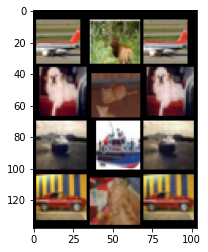

Testing generator - g_loss = 0.00043933489359915257


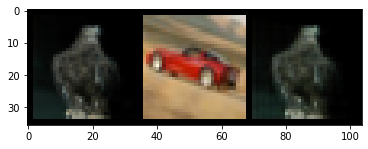

Training generator - Epoch 81 g_loss = 0.0003676844062283635
Testing generator - g_loss = 0.0004322498571127653
Training generator - Epoch 82 g_loss = 0.00035129161551594734
Testing generator - g_loss = 0.000285903865005821
Save best checkpoint with loss 0.000285903865005821
Training generator - Epoch 83 g_loss = 0.0003433014207985252
Testing generator - g_loss = 0.0004731461522169411
Training generator - Epoch 84 g_loss = 0.00036495691165328026
Testing generator - g_loss = 0.0003840340650640428
Training generator - Epoch 85 g_loss = 0.00035426649264991283
Testing generator - g_loss = 0.0008546181488782167
Training generator - Epoch 86 g_loss = 0.0003581467317417264
Testing generator - g_loss = 0.0004308673378545791
Training generator - Epoch 87 g_loss = 0.00035772897535935044
Testing generator - g_loss = 0.0004586228751577437
Training generator - Epoch 88 g_loss = 0.0003788605681620538
Testing generator - g_loss = 0.00027484705788083375
Save best checkpoint with loss 0.000274847057880

In [ ]:
# # Training generator first
# for epoch in range(100):
#     show = False
#     if epoch % 20 == 0:
#         show = True
#     train_generator(train_loader, epoch, generator, mse_criterion, show=show)
#     test_generator(test_loader, generator, mse_criterion, show=show)

In [ ]:
generator.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/checkpoints/best_generator_loss.pth'))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing generator - g_loss = 0.00027484705788083375


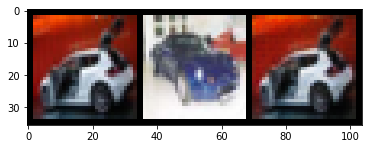

In [ ]:
test_generator(test_loader, generator, mse_criterion, show=True)

# Train and test classifier model with cifar100

In [ ]:
def prepare_dataloader_cifar100(num_workers=8,
                       train_batch_size=128,
                       eval_batch_size=256):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_set = torchvision.datasets.CIFAR100(root="data",
                                             train=True,
                                             download=True,
                                             transform=train_transform)
    
    test_set = torchvision.datasets.CIFAR100(root="data",
                                            train=False,
                                            download=True,
                                            transform=test_transform)

    train_sampler = torch.utils.data.RandomSampler(train_set)
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=train_batch_size,
                                               sampler=train_sampler,
                                               num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=eval_batch_size,
                                              sampler=test_sampler,
                                              num_workers=num_workers)

    return train_loader, test_loader

train_cifar100, test_cifar100 = prepare_dataloader_cifar100()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for epoch in range(100):
    train_classifier(train_cifar100, epoch, generator, classifier, ce_criterion, cuda=True, show=True)
    test_classifier(test_cifar100, generator, classifier, ce_criterion, cuda=True, show=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training classifier - Epoch 0 c_loss = 4.363852500915527 acc = 0.04126
Testing classifier - Epoch 0 c_loss = 4.177323341369629 acc = 0.0565
Training classifier - Epoch 1 c_loss = 3.8585851192474365 acc = 0.10552
Testing classifier - Epoch 1 c_loss = 3.6464130878448486 acc = 0.1467
Training classifier - Epoch 2 c_loss = 3.490929365158081 acc = 0.1667
Testing classifier - Epoch 2 c_loss = 3.4296939373016357 acc = 0.1814
Training classifier - Epoch 3 c_loss = 3.2074854373931885 acc = 0.21976
Testing classifier - Epoch 3 c_loss = 3.141195774078369 acc = 0.2307
Training classifier - Epoch 4 c_loss = 2.939164400100708 acc = 0.26966
Testing classifier - Epoch 4 c_loss = 2.8878490924835205 acc = 0.2815
Training classifier - Epoch 5 c_loss = 2.70070743560791 acc = 0.31744
Testing classifier - Epoch 5 c_loss = 2.6984481811523438 acc = 0.321
Training classifier - Epoch 6 c_loss = 2.499603748321533 acc = 0.3573
Testing classifier - Epoch 6 c_loss = 2.6397764682769775 acc = 0.3388
Training classifi